In [276]:
import seaborn as sns
import pandas as pd

# df = pd.read_excel('Fiat_56_Schlepp_warm_motorenbremse_2023-03-31_10-30-37.xls') # assuming your data is in a CSV file
# df = pd.read_excel('NewhollandT6.180Schlepp_motorbremse_2023-04-06_14-47-06.xls') # good one
df = pd.read_excel('NewhollandT6.175Schlepp_Motorenbremse_2023-04-06_15-14-46.xls') # good one, rolling window required
df = pd.read_excel('NewhollandT5.140Schlepp_motorbremse_2023-04-06_14-12-14.xls') # good one

*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


In [277]:
df

,Zeit,Ch1,RPM-Value
0,NaN,Channel 1,RPM-Value
1,[sec],[V],[1/min]
2,0,-0.164457,0
3,0.151012,-0.165135,0
4,0.302025,-0.165135,0
...,...,...,...
4679,706.284949,-0.020345,0
4680,706.435961,-0.019667,0
4681,706.586974,-0.020684,0
4682,706.737986,-0.020684,0


In [278]:
# remove unused excel header rows
df = df.iloc[2:]

# sensor deviation factor, as sensor did not measure very correctly
SENSOR_DEVIATION_FACTOR = df['Ch1'][:20].mean()
df['Ch1'] = df['Ch1'] - SENSOR_DEVIATION_FACTOR

# convert Ch1 [Volt] to Newtonmeter
VOLT_TO_NEWTON_FACTOR = 299.2606857
df['Ch1'] = df['Ch1'] * VOLT_TO_NEWTON_FACTOR

# subtract inefficiency from translation from motor to measuring device
INEFFICIENCY_FACTOR = 0.51
df['Ch1'] = df['Ch1'] * (1 - INEFFICIENCY_FACTOR)

# Convert Newtonmeter to negative, as its breaking force
df['Ch1'] = df['Ch1'] * (-1)

df

/tmp/ipykernel_74057/1914932999.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  SENSOR_DEVIATION_FACTOR = df['Ch1'][:20].mean()
/tmp/ipykernel_74057/1914932999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ch1'] = df['Ch1'] - SENSOR_DEVIATION_FACTOR
/tmp/ipykernel_74057/1914932999.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

,Zeit,Ch1,RPM-Value
2,0,-0.233698,0
3,0.151012,-0.134252,0
4,0.302025,-0.134252,0
5,0.453037,-0.034806,0
6,0.60405,-0.134252,0
...,...,...,...
4679,706.284949,-21.36592,0
4680,706.435961,-21.465366,0
4681,706.586974,-21.316197,0
4682,706.737986,-21.316197,0


In [279]:
# fix object to float types
df['Zeit'] = df['Zeit'].astype(float)
df['Ch1'] = df['Ch1'].astype(float)

/tmp/ipykernel_74057/1682560969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Zeit'] = df['Zeit'].astype(float)
/tmp/ipykernel_74057/1682560969.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ch1'] = df['Ch1'].astype(float)


In [280]:
df.dtypes

Zeit         float64
Ch1          float64
RPM-Value     object
dtype: object

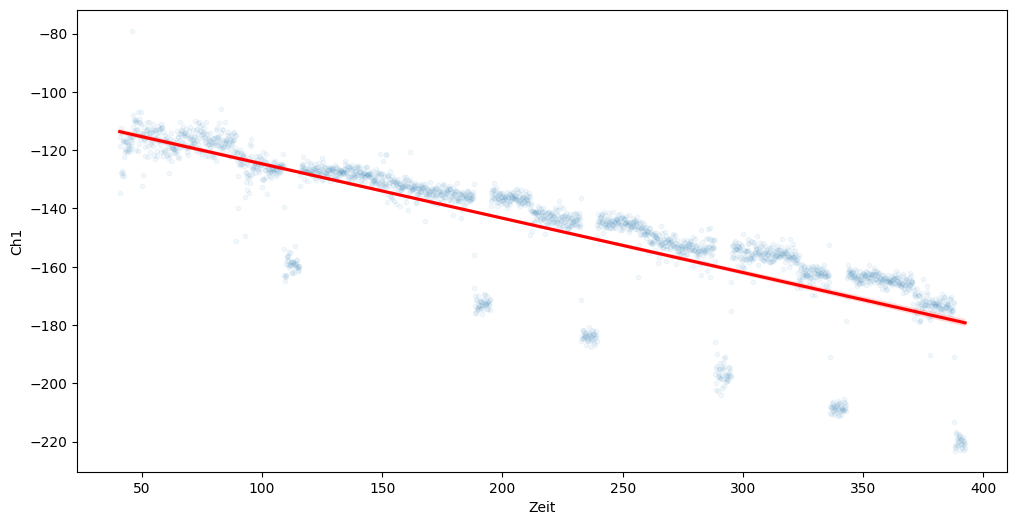

In [292]:
import matplotlib.pyplot as plt
# plot data using seaborn regplot with trendline
# df_subsampled = df[::10] # only show every 100th measurement
plt.figure(figsize=(12, 6)) # set plot size to 10 inches wide by 6 inches tall
sns.regplot(x='Zeit', y='Ch1', data=df[250:], order=1, scatter=True, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.05, 's': 10})
plt.show()

In [293]:
GOOD_START = 250
GOOD_END = len(df)
df = df[GOOD_START:GOOD_END]

# Separierung Motorenbremsdatenpunkte und normale Punkte

In [210]:
df

,Zeit,Ch1,RPM-Value
252,37.754307,260.892890,515
253,37.905324,263.835673,515
254,38.056341,259.573712,515
255,38.207358,259.979613,515
256,38.358375,259.269286,515
...,...,...,...
2997,452.296592,760.861490,1125
2998,452.447609,753.961173,1125
2999,452.598627,762.383619,1128
3000,452.749644,644.570844,1147


In [152]:
# In this example code, window=25 means that we use a 5-second rolling window,
# assuming that you have 5 samples per second. Here, rolling_mean.shift(-12) shifts
# the rolling mean by 12 samples (i.e., 3 seconds), so that it represents the future
# mean values. Then, we compute the ratio of the future rolling mean to the current rolling mean,
# and select only the periods where the ratio is less than 0.9 (i.e., an increase of at least 10%).

rolling_mean = df['Ch1'].rolling(window=15).mean()
series_increase = df['Ch1'][rolling_mean.shift(-12)/rolling_mean < 0.9]

In [153]:
import numpy as np

base_values = df.loc[~df.index.isin(series_increase.index), 'Ch1']
inc_values = df.loc[df.index.isin(series_increase.index), 'Ch1']

# Extract Zeit values for corresponding base_values and inc_values
base_zeit = df.loc[~df.index.isin(series_increase.index), 'Zeit']
inc_zeit = df.loc[df.index.isin(series_increase.index), 'Zeit']

# combine base_values and base_zeit into a single dataframe
base_df = pd.DataFrame({'Ch1': base_values, 'Zeit': base_zeit})
# combine base_values and base_zeit into a single dataframe
inc_df = pd.DataFrame({'Ch1': inc_values, 'Zeit': inc_zeit})

print(len(base_values))
print(len(inc_values))

2517
233


# rolling window plot

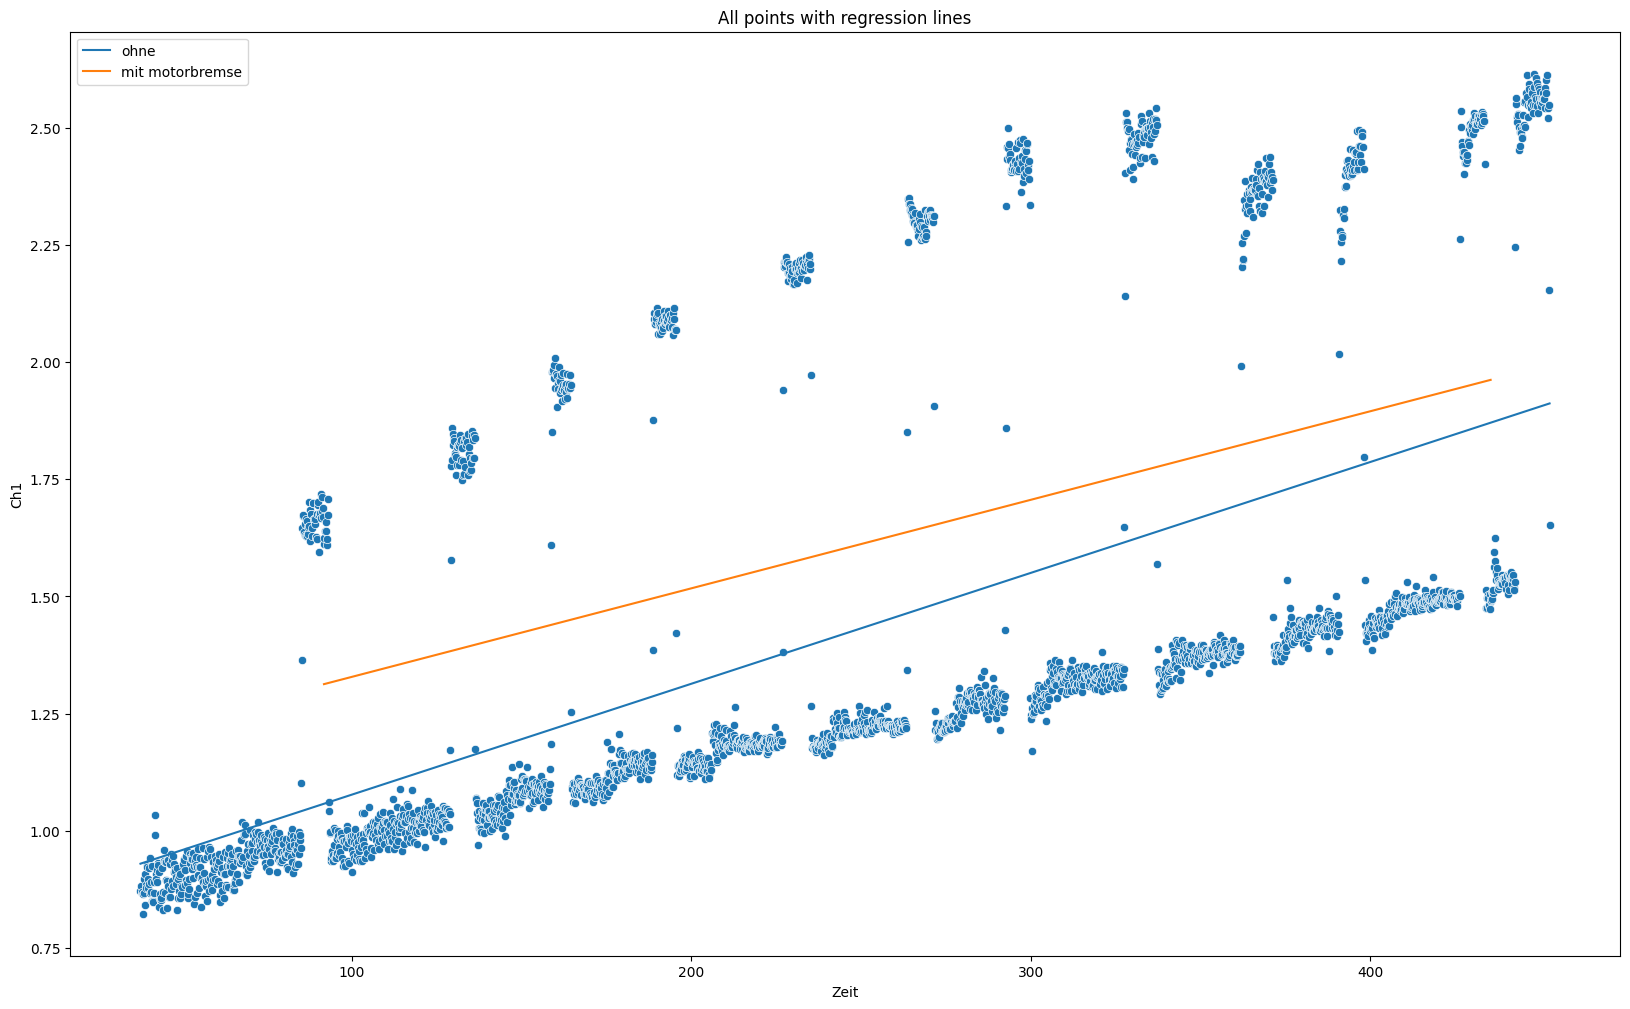

In [154]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# assume df is your original dataframe
# assume base_df and inc_df are your dataframes with base_values and inc_values respectively

# plot all points
plt.figure(figsize=(20, 12)) # set plot size to 10 inches wide by 6 inches tall

sns.scatterplot(data=df, x='Zeit', y='Ch1')

# fit and plot regression lines for base_df and inc_df
for name, data in [('ohne', base_df), ('mit motorbremse', inc_df)]:
    # fit linear regression
    coefficients = np.polyfit(data['Zeit'], data['Ch1'], 1)
    line_function = np.poly1d(coefficients)
    # plot line with label
    sns.lineplot(x=data['Zeit'], y=line_function(data['Zeit']), label=f'{name}')

# set labels and title
plt.xlabel('Zeit')
plt.ylabel('Ch1')
plt.title('All points with regression lines')

# show legend
plt.legend()

# show plot
plt.show()


# simple threshold separation plot

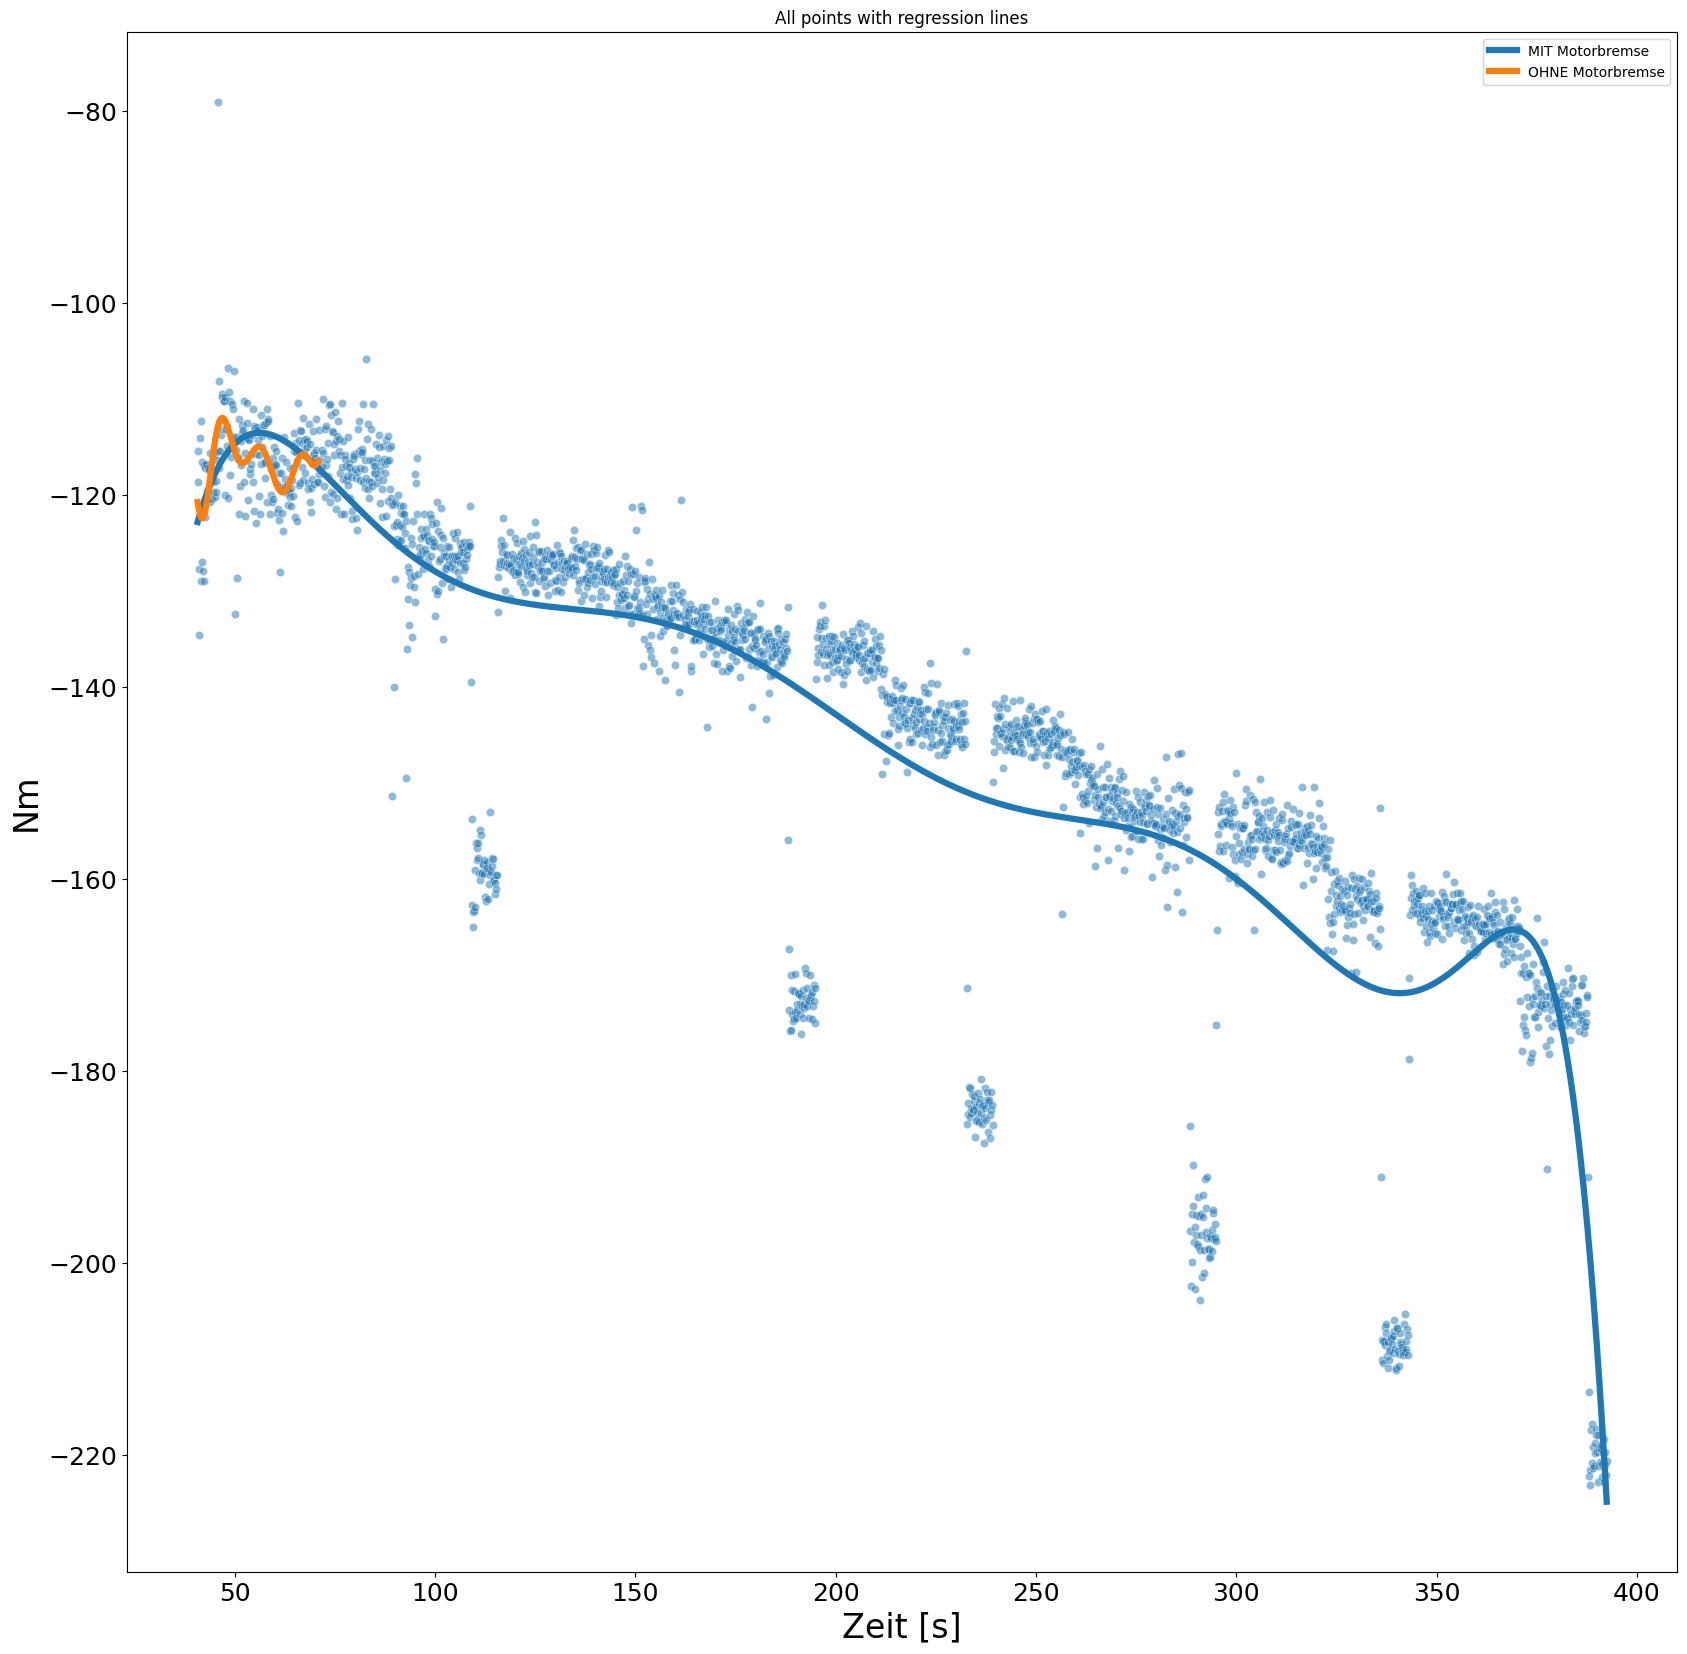

In [294]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# assume df is your original dataframe
# assume base_df and inc_df are your dataframes with base_values and inc_values respectively

## df['Ch1'] = toto['Ch1'] * (-1)
# plot all points
plt.figure(figsize=(20, 20)) # set plot size to 10 inches wide by 6 inches tall

sns.scatterplot(data=df, x='Zeit', y='Ch1', alpha=0.5)

CUTOFF = -243

base_df_thresh = df[df['Ch1'] > CUTOFF]
inc_df_thresh = df[df['Ch1'] < CUTOFF]
# add the first 100 points to base_df_tresh
# base_vals = base_df_thresh.values[:200]

# Assuming base_df_thresh and inc_df_thresh are already defined
# Extract the first 200 values from base_df_thresh, and convert to a numeric data type
base_vals = pd.to_numeric(base_df_thresh.iloc[:200].values.flatten(), errors='coerce').reshape(-1, len(base_df_thresh.columns))
# Prepend the base_vals to inc_df_thresh
inc_df_thresh = pd.concat([pd.DataFrame(base_vals, columns=inc_df_thresh.columns), inc_df_thresh], axis=0)

# Now inc_df_thresh has the first 200 points from base_df_thresh prepended to it!



# Prepend the base_vals to inc_df
# inc_df_thresh = pd.concat([pd.DataFrame(base_vals, columns=inc_df_thresh.columns), inc_df_thresh], axis=0)

# print(inc_df_thresh)

# fit and plot regression lines for base_df and inc_df
for name, data in [('MIT Motorbremse', base_df_thresh), ('OHNE Motorbremse', inc_df_thresh)]:
    # fit linear regression
    coefficients = np.polyfit(data['Zeit'], data['Ch1'], 10)
    line_function = np.poly1d(coefficients)
    # plot line with label
    sns.lineplot(x=data['Zeit'], y=line_function(data['Zeit']), label=f'{name}', linewidth=4.5)

    # Plot the data points and the fitted line
#     sns.lineplot(x='Zeit', y='Ch1', data=data)
#     sns.lineplot(x=data['Zeit'], y=np.polyval(coefficients, data['Zeit']), ci=None)
    

# set labels and title
plt.xlabel('Zeit [s]', fontsize=24)
plt.ylabel('Nm', fontsize=24)
plt.title('All points with regression lines')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# show legend
plt.legend()

# show plot
plt.show()


In [241]:
plt.savefig('experiment.png')

<Figure size 640x480 with 0 Axes>

In [253]:
!pip install xlwt

     |████████████████████████████████| 99 kB 1.8 MB/s eta 0:00:01


In [257]:
base_df_thresh.to_excel("NewhollandT6.180Schlepp_motorbremse_2023-04-06_14-47-06_MIT.xls")
inc_df_thresh.to_excel("NewhollandT6.180Schlepp_motorbremse_2023-04-06_14-47-06_OHNE.xls")

/tmp/ipykernel_74057/4086525816.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  base_df_thresh.to_excel("NewhollandT6.180Schlepp_motorbremse_2023-04-06_14-47-06_MIT.xls")
/tmp/ipykernel_74057/4086525816.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning